# Battle of the Neighborhoods: Venues of Mumbai

# Introduction

This projects explores different venues in the city of Mumbai, for which Foursquare data is used to compare and explore the different neighborhoods within the city

## Problem description
Mumbai is a costal city of India, located at the western side of Maharashtra. Mumbai is the 7th most populated city in the World, and the 2nd most populas city in India. Mumbai has a vast history, from Vasco Da Gama, to being the capital of the state, to iconic hotels.

With so much population, finding the right business in Mumbai can lead to a lot of sucess, lots of customers = lots of profit. The question that arises is what kind of business should one look into, what king of things do the people of Mumbai like?

## Targe Audience
This project could be use by somebody who wants to start a business in Mumbai, that provides some service to the people residing there. One can check what kind of taste do the residants of Mumbai posses and where would one set up his/her business to serve the needs of the people.

## Data Description
There are 2 sources of data used in this project. The first one is a wikipedia page https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai that contains the list of areas of Mumbai and their respective coordinates. The second source of data, is the venue data of different neighborhoods, which is gathered by using Folium API.

# Methodoly
Here, the first step carried is scrapping the data from the webpage using BeautifulSoup and processing it to get the details of different areas of Mumbai.

### Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np

!pip install folium
import folium

import requests
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install seaborn
import seaborn as sns

In [142]:
# capture the data from the webpage
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
page = requests.get(url).text
soup = BeautifulSoup(page, 'html5lib')

In [143]:
areas = []
locations = []
longitudes = []
latitudes = []

for row in soup.table.find_all('tr')[1:]:
    area = row.find_all('td')[0].text.strip()
    location =row.find_all('td')[1].text.strip()
    latitude = row.find_all('td')[2].text.strip()
    longitude = row.find_all('td')[3].text.strip()
    
    areas.append(area)
    locations.append(location)
    latitudes.append(latitude)
    longitudes.append(longitude)
    

In [187]:
df = pd.DataFrame(data = {
    'Neighborhood' : areas,
    'Location' : locations,
    'Latitude': map(float, latitudes),
    'Longitude': map(float, longitudes)
    
})

In [188]:
df

,Neighborhood,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,"Tardeo,South Mumbai",18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850


### Using the geocode library to get the cooridnates of the city

In [189]:
address = 'Mumbai, India'

geolocator = Nominatim(user_agent="mumbai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Mumbai are 19.0759899, 72.8773928.


### Plotting the neighborhoods of the city using folium library

In [190]:
mumbai_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add neighborhood markers to map
for lat, lng, location, area in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Location']):
    label = '{}, {}'.format(area, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mumbai_map) 
mumbai_map

### Details required for using the Foursquare API

In [191]:
CLIENT_ID = '' # Foursquare ID
CLIENT_SECRET = '' # Foursquare Secret
ACCESS_TOKEN = '' # FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X3SSIHFCKZ3CO3UGTNWZ0DKJZBILG1CF1TE1SNFGCJ0AIDEW
CLIENT_SECRET:VAELWTD4LC35GKKBXIIIMTGFRADLSKGC0B13SIB3Y2AOQ5A4


### Next we get the nearby venues for a given location that lie with 500 meters
### After getting the venues, exploratory analysis is performed to know the data better

In [193]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [194]:
mumbai_venues = getNearbyVenues(names = df['Neighborhood'],
                                 latitudes = df['Latitude'],
                                 longitudes = df['Longitude']
                                 )

print(mumbai_venues.shape)
mumbai_venues.head()

(1278, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.129300,72.843400,Cafe Arfa,19.128930,72.847140,Indian Restaurant
1,Amboli,19.129300,72.843400,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
2,Amboli,19.129300,72.843400,Subway,19.127860,72.844461,Sandwich Place
3,Amboli,19.129300,72.843400,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
4,"Chakala, Andheri",19.111388,72.860833,Courtyard Mumbai International Airport,19.114167,72.864131,Hotel


In [195]:
mumbai_venues['Venue Category'].value_counts()[:20]

Indian Restaurant                160
Café                              79
Fast Food Restaurant              53
Coffee Shop                       51
Bakery                            44
Chinese Restaurant                41
Bar                               40
Ice Cream Shop                    38
Pizza Place                       34
Restaurant                        31
Dessert Shop                      27
Italian Restaurant                24
Snack Place                       23
Hotel                             21
Seafood Restaurant                21
Sandwich Place                    18
Lounge                            15
Electronics Store                 15
Vegetarian / Vegan Restaurant     15
Department Store                  14
Name: Venue Category, dtype: int64

## Here are the top 10 most common venue categories

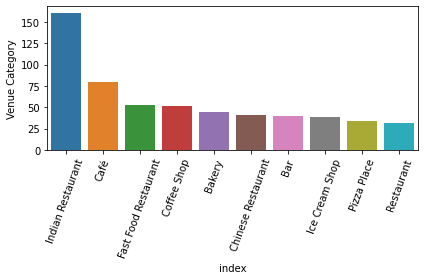

In [196]:
sns.barplot(x='index', y='Venue Category', 
            data=mumbai_venues['Venue Category'].value_counts().to_frame().reset_index()[:10])
plt.xticks(rotation=70)
plt.tight_layout()

## Analyzing each neighborhood for top 10 venues
## One hot encoding

In [197]:
mumbai_onehot = pd.get_dummies(mumbai_venues['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Neighborhood'] = mumbai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = mumbai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
mumbai_onehot = mumbai_onehot.reindex(columns = fixed_columns)

print(mumbai_onehot.shape)
mumbai_onehot.head()

(1278, 167)


,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,...,Theater,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Chakala, Andheri",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
mumbai_grouped = mumbai_onehot.groupby('Neighborhood').mean().reset_index()
print(mumbai_grouped.shape)
mumbai_grouped.head()

(86, 167)


,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Asian Restaurant,BBQ Joint,...,Theater,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agripada,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Altamount Road,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amboli,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Amrut Nagar,0.0,0.027027,0.027027,0.0,0.0,0.0,0.0,0.027027,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Asalfa,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [236]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mumbai_grouped['Neighborhood']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agripada,Bakery,Indian Restaurant,Gym,Coffee Shop,Convenience Store,Dhaba,Falafel Restaurant,Event Space,Electronics Store,Donut Shop
1,Altamount Road,Café,Coffee Shop,Theater,Bakery,Indian Restaurant,Sandwich Place,Cupcake Shop,Event Space,Electronics Store,Donut Shop
2,Amboli,Coffee Shop,Sandwich Place,Chinese Restaurant,Indian Restaurant,Yoga Studio,Dhaba,Event Space,Electronics Store,Donut Shop,Dog Run
3,Amrut Nagar,Indian Restaurant,Café,Clothing Store,Restaurant,Electronics Store,Fast Food Restaurant,Chinese Restaurant,Paper / Office Supplies Store,Park,Mediterranean Restaurant
4,Asalfa,Park,Bus Station,Dessert Shop,Event Space,Electronics Store,Donut Shop,Dog Run,Diner,Dim Sum Restaurant,Dhaba


### Lastly, KNN was used to cluster the data into 5 clusters, and plot the clusters on the map

In [237]:
# set number of clusters
kclusters = 5

mumbai_grouped_clustering = mumbai_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [238]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mumbai_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mumbai_merged.dropna(inplace=True)
mumbai_merged.head()

,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400,0.0,Coffee Shop,Sandwich Place,Chinese Restaurant,Indian Restaurant,Yoga Studio,Dhaba,Event Space,Electronics Store,Donut Shop,Dog Run
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,0.0,Hotel,Multiplex,Pizza Place,Café,Restaurant,Fast Food Restaurant,Cocktail Bar,Salon / Barbershop,Falafel Restaurant,Seafood Restaurant
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,0.0,Indian Restaurant,Gym / Fitness Center,Snack Place,Pizza Place,Bus Line,Dessert Shop,Electronics Store,Donut Shop,Dog Run,Diner
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210,0.0,Gym,Women's Store,Juice Bar,Vegetarian / Vegan Restaurant,Residential Building (Apartment / Condo),Smoke Shop,Market,Pizza Place,Fish Market,Playground
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270,0.0,Department Store,Lounge,Ice Cream Shop,Pizza Place,Market,Residential Building (Apartment / Condo),Pub,Indian Restaurant,Coffee Shop,Liquor Store


## Results

In [243]:
mumbai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Neighborhood'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(mumbai_clusters_map)
       
mumbai_clusters_map

# Discussion
## Examining the Clusters


### Cluster 1
CLuster that contains a variety of venues that people use in the daily life. Ranging from entertainment, food, health, to essentials and shops.

In [260]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0, mumbai_merged.columns[[1] + list(range(5, mumbai_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Andheri,Western Suburbs",Coffee Shop,Sandwich Place,Chinese Restaurant,Indian Restaurant,Yoga Studio,Dhaba,Event Space,Electronics Store,Donut Shop,Dog Run
1,Western Suburbs,Hotel,Multiplex,Pizza Place,Café,Restaurant,Fast Food Restaurant,Cocktail Bar,Salon / Barbershop,Falafel Restaurant,Seafood Restaurant
2,"Andheri,Western Suburbs",Indian Restaurant,Gym / Fitness Center,Snack Place,Pizza Place,Bus Line,Dessert Shop,Electronics Store,Donut Shop,Dog Run,Diner
3,"Andheri,Western Suburbs",Gym,Women's Store,Juice Bar,Vegetarian / Vegan Restaurant,Residential Building (Apartment / Condo),Smoke Shop,Market,Pizza Place,Fish Market,Playground
4,"Andheri,Western Suburbs",Department Store,Lounge,Ice Cream Shop,Pizza Place,Market,Residential Building (Apartment / Condo),Pub,Indian Restaurant,Coffee Shop,Liquor Store
...,...,...,...,...,...,...,...,...,...,...,...
88,South Mumbai,Indian Restaurant,Electronics Store,Asian Restaurant,Plaza,Department Store,Event Space,Donut Shop,Dog Run,Diner,Dim Sum Restaurant
89,"Tardeo,South Mumbai",Café,Coffee Shop,Bar,Deli / Bodega,Clothing Store,Bus Station,Restaurant,Brewery,Salon / Barbershop,Bookstore
90,South Mumbai,Indian Restaurant,Fast Food Restaurant,Bar,Multiplex,Middle Eastern Restaurant,Cheese Shop,Café,Market,Restaurant,Electronics Store
91,Mumbai,Fast Food Restaurant,Juice Bar,Café,Coffee Shop,Convenience Store,Creperie,Event Space,Electronics Store,Donut Shop,Dog Run


## Cluster 2 
This cluster seems to contain places that one can visit like Multiplex, Event Space, Yoga Studio.
This cluster doesn't seem to have a bias towards restaurants, like cluster 1.

In [257]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1, mumbai_merged.columns[[2] + list(range(5, mumbai_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,19.13,Multiplex,Yoga Studio,Dessert Shop,Event Space,Electronics Store,Donut Shop,Dog Run,Diner,Dim Sum Restaurant,Dhaba


## Cluster 3
This cluter contains the region nearby shipping store

In [258]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2, mumbai_merged.columns[[2] + list(range(5, mumbai_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,19.29,Shipping Store,Dessert Shop,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Dog Run,Diner,Dim Sum Restaurant,Dhaba


## Cluster 4
This cluster is heavly influeced by Indian Restaurants and food places.

In [259]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 3, mumbai_merged.columns[[2] + list(range(5, mumbai_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,19.415400,Bus Station,Indian Restaurant,Yoga Studio,Dessert Shop,Event Space,Electronics Store,Donut Shop,Dog Run,Diner,Dim Sum Restaurant
42,19.157000,Indian Restaurant,Restaurant,Ice Cream Shop,Yoga Studio,Dessert Shop,Event Space,Electronics Store,Donut Shop,Dog Run,Diner
54,18.950000,Indian Restaurant,Cheese Shop,Market,Restaurant,Food,Ice Cream Shop,Fast Food Restaurant,American Restaurant,Dance Studio,Diner
80,18.977129,Indian Restaurant,Bakery,Dessert Shop,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Dog Run,Diner,Dim Sum Restaurant
84,18.948140,Indian Restaurant,Café,Train Station,Event Space,Electronics Store,Donut Shop,Dog Run,Diner,Dim Sum Restaurant,Dhaba
85,18.951811,Indian Restaurant,Fast Food Restaurant,Food,Bus Station,Dhaba,Event Space,Electronics Store,Donut Shop,Dog Run,Diner


## Cluster 5
This cluster lies in the southern part of the city and contains Gardens, yoga studio, dog run, etc. suggestion a high standard emerging area.

In [261]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 4, mumbai_merged.columns[[2] + list(range(5, mumbai_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,18.91,Garden,Yoga Studio,Dessert Shop,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Dog Run,Diner,Dim Sum Restaurant


# Conclusion

Due to the huge customer base in Mumbai, you can run wide vareity of businees in the city. Cluster 1 is spread thorought the city, hence any place there can work.
The other option could be to targer the people of cluster 4 by setting up a restaurant or a food place, as the people of this cluster are foodies.
Finally, one could set up a niche and unique business to target the people of the southern part of the city.

# Refernces 

* List of neighbourhoods in Mumbai : https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai  
* Foursquare api        